In [2]:
import veroviz as vrv

In [3]:
# def calcCost(route, costDict):
#     '''
#     Calculates the total cost of a TSP route.
    
#     route -- Should be a python list containing a sequence of nodes to be visited.
#     costDict -- A VeRoViz time/distance "matrix"
#     '''
    
#     # FIXME -- Can do this more efficiently
#     totalCost = 0
#     for i in range(0,len(route)-1):
#         print("{} to {}".format(route[i], route[i+1]))
#         totalCost += costDict[route[i], route[i+1]]
     
#     return totalCost

## Edit the following cell to import the proper data sets:

In [30]:
myNodes  = vrv.importDataframe(filename='1000nodes/nodes.csv')

timeSec = vrv.importDataFromCSV(dataType='matrix', filename='1000nodes/cost.csv')

len(costDict), nodesDF

(100,
    id        lat        lon  altMeters  nodeName  nodeType  popupText  \
 0   0  42.934682 -78.779242          0  customer       NaN          0   
 1   1  42.952680 -78.865989          0  customer       NaN          1   
 2   2  42.981909 -78.792784          0  customer       NaN          2   
 3   3  42.968612 -78.897910          0  customer       NaN          3   
 4   4  42.997545 -78.880474          0  customer       NaN          4   
 5   5  42.994158 -78.758362          0  customer       NaN          5   
 6   6  42.960235 -78.825312          0  customer       NaN          6   
 7   7  42.959520 -78.874270          0  customer       NaN          7   
 8   8  42.959924 -78.825658          0  customer       NaN          8   
 9   9  42.981076 -78.785667          0  customer       NaN          9   
 
   leafletIconPrefix leafletIconType leafletColor  leafletIconText  \
 0         glyphicon       info-sign         blue                0   
 1         glyphicon       info-sign  

--- 

## Edit the following cell to solve the problem using your Simulated Annealing heuristic

In [6]:
import veroviz as vrv
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
import datetime
from datetime import timedelta

In [7]:
def tspNN(nodesDF, costDict, startNode):
    
    '''
    Return an ordered list of node IDs representing a TSP tour/route,
    using the nearest neighbor heuristic.
    '''
    
    route = []
    
    # Start route at startNode
    route.append(startNode)
    
    # Initialize a list of unvisited nodes
    unvisitedNodes = list(nodesDF[nodesDF['id'] != startNode]['id'])
    
    # Let i represent our "current" location
    i = startNode
    
    while len(unvisitedNodes) > 0:
        # Initialize minCost to a huge value
        minCost = float('inf')
        
        for j in unvisitedNodes:
            if (costDict[i,j] < minCost):
                nextNode = j
                minCost = costDict[i,j]

        # Append the "next" customer to our route:
        route.append(nextNode)
        
        # Update our salesperson's current location:
        i = nextNode
        
        # Remove this location from unvisitedNodes:
        unvisitedNodes.remove(i)
    
    # Go back to start
    route.append(startNode)
    
    return route                

In [8]:
def calcCost(route, costDict):
    
    totalCost = 0
    
    for i in range(0, len(route)-1):
        totalCost += costDict[route[i], route[i+1]]
     
    return totalCost

In [9]:
def adjacent(route, rnd):
    
    '''
    By swapping two randomly selected elements of the current solution -except for the origin and destination-,
    an adjacent proposed solution is created
    '''
    
    import numpy as np
    
    n = len(route)
#     result = np.copy(route)
#     i = rnd.randint(1, n-1); j = rnd.randint(1, n-1)
#     tmp = result[i]
#     result[i] = result[j]; result[j] = tmp
    
    #import random as rnd
    lis = route
    #n = len(lis)
    i_temp = rnd.randint(1, n-1); j_temp = rnd.randint(1, n-1)
    i = min(i_temp,j_temp)
    j= max(i_temp,j_temp)
    listmid1 = lis[i:j+1]
    listmid2 = listmid1[::-1]
    #print(lis)
    #print(i,j)
    #print(listmid2)
    result = route[0:i]+listmid2+route[j+1:]
    #print(final_list)

    return result

In [10]:
def annealing(nodesDF, costDict, startNode, rnd, max_iter, start_temperature, alpha):
    
    '''
    Main body of the simulated annealing.
    '''

    cost= []
    iterations = []
    temp = []
    
    # solve using simulated annealing
    curr_temperature = start_temperature
    
    x_cur = tspNN(nodesDF, costDict, startNode)
    x_best = x_cur
    
    print("Initial guess: ")
    print(x_cur)

    z_cur = calcCost(x_cur, costDict)
    z_best = z_cur
    
    iteration = 0
    interval = (int)(max_iter / 20)
    accept_p = 0.0

    #currentRunTimeSeconds = (datetime.datetime.now()-timeStart).total_seconds
    while iteration < max_iter and z_cur > 0.0:
    #while currentRunTimeSeconds < timeLimit and z_cur > 0.0:
        x_count = adjacent(x_cur, rnd)
        z_count = calcCost(x_count, costDict)
        
        if z_cur < z_best:
            x_best = x_cur; z_best = z_cur
        
        if z_count < z_cur:  # better route so accept
            x_cur = x_count; z_cur = z_count
        else:          # adjacent is worse
            accept_p = np.exp((z_cur - z_count) / curr_temperature)
            p = rnd.random()
            if p < accept_p:  # accept anyway
                x_cur = x_count; z_cur = z_count 
            # else don't accept

            if iteration % interval == 0:
                print("iter = %d | curr distance = %0.2f | temperature = %0.2f " %(iteration, z_cur, curr_temperature))
                cost.append(z_cur)
                iterations.append(iteration)
                temp.append(curr_temperature)

            if curr_temperature < 0.00001:
                curr_temperature = 0.00001
            else:
                curr_temperature *= alpha
            iteration += 1
    
    return x_best, cost, iterations, temp   

In [11]:
def see_annealing(iterations, costs):
    
    Spline = make_interp_spline(iterations, costs)  
    X_ = np.linspace(min(iterations), max(iterations), 500)
    Y_ = Spline(X_)
    
    y1 = min(costs)
    
    plt.figure(figsize=(14, 6), dpi=80)
    plt.suptitle("Evolution of costs for TSP Simulated Annealing")
    plt.subplot(121)
    
    plt.plot(X_, Y_,  'r', label='Smoothed movement of Z_curr')
    plt.axhline(y=y1, color='r', linestyle='--', label='Z(best)')
    
    plt.xlabel("No. of Iterations")
    plt.ylabel("Costs")
    #plt.ylim(ymin=0)
    plt.xlim(xmin=0)
    plt.grid(color='grey', linestyle='-', linewidth=0.5)   
    plt.legend()


Begin TSP simulated annealing demo 

Setting num_cities = 1000 

Settings: 
max_iter = 750000 
start_temperature = 1000.0 
alpha = 1.00 

Starting annealing() 
Initial guess: 
[0, 726, 720, 750, 248, 129, 880, 689, 938, 876, 982, 828, 918, 364, 188, 606, 332, 833, 428, 866, 294, 174, 717, 327, 657, 898, 173, 94, 469, 267, 302, 441, 663, 546, 680, 574, 927, 340, 569, 213, 842, 901, 314, 236, 171, 820, 780, 744, 492, 440, 430, 123, 37, 748, 104, 666, 544, 328, 44, 769, 847, 166, 598, 505, 681, 179, 121, 911, 879, 375, 392, 67, 701, 161, 636, 97, 956, 303, 415, 854, 337, 712, 329, 230, 75, 984, 932, 664, 45, 391, 803, 147, 372, 760, 639, 105, 501, 749, 640, 374, 261, 116, 595, 277, 443, 571, 993, 393, 30, 319, 972, 420, 359, 199, 551, 945, 758, 776, 740, 654, 210, 728, 562, 98, 843, 868, 55, 323, 290, 90, 221, 994, 971, 541, 647, 366, 295, 73, 126, 596, 884, 207, 220, 762, 237, 42, 353, 798, 990, 225, 426, 53, 460, 384, 271, 445, 949, 802, 274, 952, 311, 561, 19, 624, 838, 679, 195, 15, 

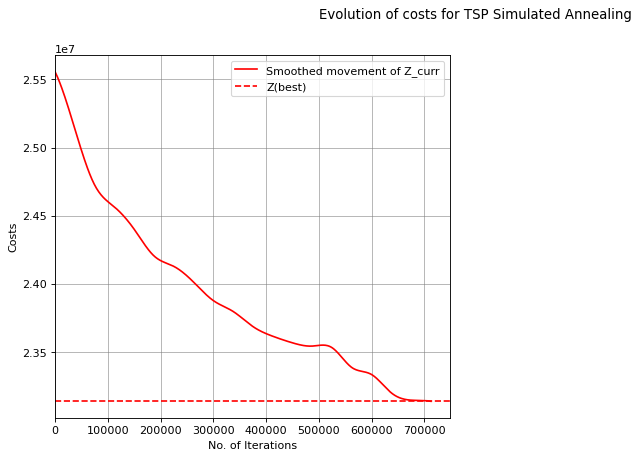

In [32]:
def main():
    

    
    print("\nBegin TSP simulated annealing demo ")
    
    
    nodesDF = myNodes
    costDict = timeSec
    
#     nodesDF = vrv.importDataFromCSV('.csv')
    startNode = 0
    print("\nSetting num_cities = %d " % nodesDF.shape[0])

    rnd = np.random.RandomState(4) 
    max_iter = 750000
    start_temperature = 1000.0
    alpha = 0.9999

    print("\nSettings: ")
    print("max_iter = %d " % max_iter)
    print("start_temperature = %0.1f " % start_temperature)
    print("alpha = %0.2f " % alpha)
  
    print("\nStarting annealing() ")
    
    soln, cost, iterations, temp = annealing(nodesDF, costDict, startNode, rnd, max_iter, start_temperature, alpha)
    print("Finished annealing() ")

    print("\nBest solution found: ")
    print(soln)
    dist = calcCost(soln, costDict)
    print("\nTotal distance = %0.5f " % dist)

    see_annealing(iterations, cost)

    print("\nEnd demo ")

if __name__ == "__main__":
    start = time.time()
    main()
    end = time.time()
    print ("Time elapsed: %.5f" % (end - start))

In [29]:
#(10812891.30465-9899193.6)/11556000

0.07906695263499479

In [ ]:
'''
route = solveTSPsimAnneal(nodesDF, costDict)

calcCost(route, costDict)
'''

--- 

## Now, display your solution on a map:

In [ ]:
arcsDF = vrv.createArcsFromNodeSeq(nodeSeq=route, nodes=nodesDF)
vrv.createLeaflet(nodes=nodesDF, arcs=arcsDF)

---
## Optional -- Solving with Gurobi
- The code below is for your reference only.  It is not necessary for today's in-class contest.

In [15]:
import gurobipy as gp
from gurobipy import GRB
from collections import defaultdict

# Create dictionaries with arbitrary depth
def nested_dict():
    return defaultdict(nested_dict)

def solveGurobi(myNodes, timeSec, timeLimit):
    '''
    nodesDF   -- A VeRoViz "nodes" dataframe
    costDict  -- A VeRoViz time/distance "matrix"
    timeLimit -- The max number of seconds you're willing to allow Gurobi to run.  
                 Set this to -1 if you don't want a limit.
    '''
    
    # Initialize decision variable data structures:
    u = {}
    x = defaultdict(nested_dict)
    
    # ***************************************************
    # The following parameters -- including sets, lists,
    # dictionaries, and scalars -- were detected by
    # tex2solver.
    #
    # You will need to define values for these.
    # Otherwise, Python will complain.
    # ***************************************************
    # Parameters:
    n = len(nodesDF) - 1 # n is the number of customers; Node 0 is assumed to be the depot.
    d = costDict         # 

    myModel = gp.Model("OptModel")
    # decvar: x
    for i in range(0,n+1):
        for j in range(0,n+1):
            if j != i:
                x[i][j] = myModel.addVar(lb=0, ub=1, vtype=GRB.BINARY, name="x_%s_%s" % (i,j))

    # decvar: u
    for i in range(1,n+1):
        u[i] = myModel.addVar(lb=0, vtype=GRB.CONTINUOUS, name="u_%s" % (i))

    # objective
    myModel.setObjective(gp.quicksum(d[i,j]*x[i][j] for i in range(0,n+1) for j in range(0,n+1) if j != i), GRB.MINIMIZE)

    # con:2
    for j in range(1,n+1):
        myModel.addConstr(gp.quicksum(x[i][j] for i in range(0,n+1) if i != j) == 1)

    # con:3
    for i in range(1,n+1):
        myModel.addConstr(gp.quicksum(x[i][j] for j in range(0,n+1) if j != i) == 1)

    # con:4
    for i in range(1,n+1):
        for j in range(1,n+1):
            if i != j:
                myModel.addConstr(u[i] - u[j] + (n*x[i][j]) <= n - 1)


    # Solve
    if (timeLimit > 0):
        myModel.setParam('TimeLimit', timeLimit)
    myModel.optimize()

    route = []

    print('\n-------- Solution Details --------\n')
    if (myModel.Status == GRB.INFEASIBLE):
        # No Feasible Solution Exists
        print('No feasible solution exists.')

        print('Computing IIS...')
        myModel.computeIIS()
        # The following constraint(s) cannot be satisfied:
        for q in myModel.getConstrs():
            if q.IISConstr:
                print('%s' % q.constrName)
    elif (myModel.status == GRB.UNBOUNDED):
        print('Unbounded.')

    elif (myModel.status == GRB.INF_OR_UNBD):
        print('Infeasible or Unbounded.')

    elif (myModel.Status == GRB.TIME_LIMIT) and (((myModel.modelSense == GRB.MINIMIZE) and (myModel.objVal > 1e30)) or ((myModel.modelSense == GRB.MAXIMIZE) and (myModel.objVal < -1e30))):
        # No Feasible Solution was Found
        # (maybe one exists, but we ran out of time)
        print('No feasible solution was found within the time limit.')

    else:
        # A Feasible Solution was Found
        print('Objective Function Value:', myModel.objVal)

        if (myModel.Status == GRB.OPTIMAL):
            print('\tThis is the optimal objective function value')
        elif (myModel.Status == GRB.TIME_LIMIT):
            print('\tTime limit reached.\n')
            print('\tBest Bound:', myModel.ObjBound)

        # Print solution
        print('\nSolution:')
        for var in myModel.getVars():
            if (abs(var.X) > myModel.Params.INT_FEAS_TOL):
                # Only display non-zero values
                print('\t', var.VarName, "=", var.X)

        print('\nRoute:')
        i = 0
        route.append(i)
        keepGoing = True
        while keepGoing:
            for j in range(0, n+1):
                if j != i:
                    if x[i][j].X > 0.001:
                        route.append(j)
                        if j == 0:
                            keepGoing = False
                        else:
                            i = j
                        break

        print(route)
        
    return route

ModuleNotFoundError: No module named 'gurobipy'

In [18]:
optimalRoute = solveGurobi(nodesDF, costDict, -1)

optimalArcsDF = vrv.createArcsFromNodeSeq(nodeSeq=optimalRoute, nodes=nodesDF)

Gurobi Optimizer version 9.0.3 build v9.0.3rc0 (mac64)
Optimize a model with 90 rows, 99 columns and 378 nonzeros
Model fingerprint: 0x98f7eaeb
Variable types: 9 continuous, 90 integer (90 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+00]
  Objective range  [4e+01, 1e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+00]
Found heuristic solution: objective 127171.07479
Presolve removed 0 rows and 18 columns
Presolve time: 0.00s
Presolved: 90 rows, 81 columns, 360 nonzeros
Variable types: 9 continuous, 72 integer (72 binary)

Root relaxation: objective 1.709874e+04, 23 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 17098.7378    0   12 127171.075 17098.7378  86.6%     -    0s
H    0     0                    66228.338219 17098.7378  74.2%     -    0s
H    0     0                    55880.946204 17098.7378  69.4%  

In [17]:
vrv.createLeaflet(nodes=nodesDF, arcs=optimalArcsDF)